In [3]:
using JLD2
include("MDPModelFunctions2.jl")
include("setupPythonPlot.jl")

using DataFrames

In [4]:
# experiment 1....

# row is 2 obj vs 4 obj
# col is 2 pre-cue, 2 neutral, 2 retro-cue, 2 neutral, 4 pre-cue, 4 neutral, 4 retro-cue, 4 neutral

exp1_cowan_k_true_7_yr = [1.16 1.14 1.13 1.02 2.80 .91 1.30 .96]'
exp1_cowan_k_true_adult = [1.98 1.94 1.97 1.95 3.87 2.66 3.64 2.87]'

# experiment 2 - 4 objects
# col is IM cued, IM neutral, VSTM cued, VSTM neutral

exp2_cowan_k_true_7_yr = [1.55 1.16 1.00 0.69]'
exp2_cowan_k_true_adult = [3.54 2.58 3.58 2.65]'

# experiment 3

# Load 3 cued, Load 3 Neutral, Load 6 cued, Load 6 neutral
IM_true_7_yr = [1.44 1.27 1.82 0.88]
Short_VSTM_true_7_yr = [1.14 0.77 NaN NaN]
Long_VSTM_true_7_yr = [1.19 0.90 NaN NaN]

exp3_cowan_k_true_7_yr = [IM_true_7_yr; Short_VSTM_true_7_yr; Short_VSTM_true_7_yr]


IM_true_adult = [2.63 2.41 4.80 2.46]
Short_VSTM_true_adult = [2.75 2.38 3.97 2.15]
Long_VSTM_true_adult = [2.76 2.30 3.65 1.75]

exp3_cowan_k_true_adult = [IM_true_adult; Short_VSTM_true_adult; Short_VSTM_true_adult]


3×4 Matrix{Float64}:
 2.63  2.41  4.8   2.46
 2.75  2.38  3.97  2.15
 2.75  2.38  3.97  2.15

In [5]:
## Specify parameters for each job and load all results...

eps_vals = collect(.99:-.05:.15) # 17
N_eps = length(eps_vals)

# quanta values
q_vals = collect(5:5:100)
N_q = length(q_vals)

mem_slopes = [.1, .2, .1, .4, .2]
N_ms = length(mem_slopes)

# re-run with new values so we can see some concavity...
NT_vals = [3200, 400, 1600, 800, 800] # run w these now... 
N_nt = length(NT_vals)

N_hyp = N_nt

5

In [6]:

function load_results(epsilon, N_Quanta, NT_per_Second, mem_slope; exp_num = 2, on_cluster = false)
    
    if on_cluster
        to_save_folder = "/home/erussek/projects/Memory_Models/shimi_all_parameter_search_fine"
    else
        to_save_folder = "/Users/erussek/Dropbox/Griffiths_Lab_Stuff/code/Memory_Models/shimi_all_parameter_search_fine/exp$(exp_num)"
    end
    
    local file_name = "N_Quanta_$(N_Quanta)_epsilon_$(epsilon)_NT_per_Second_$(NT_per_Second)_memslope_$(mem_slope).jld2"
    
    local full_file_path = joinpath(to_save_folder,file_name)

    res = load(full_file_path)
    
    return res["job_res_$(exp_num)"]
end

function format_res_cowan_k(res; exp_num = 1)
    
    if exp_num == 1
    
        # row is 2 obj vs 4 obj
        # col is pre-cue, neutral, retro-cue, neutral
        
        part_pcorr = res[:,:,end];
        model_cowan_p_corr = [part_pcorr; part_pcorr[2,:]']'
        model_cowan_k_mtx = cowan_k(model_cowan_p_corr, 2)
        model_cowan_k_mtx[2,:] = cowan_k(model_cowan_p_corr[2,:], 4)
        
        model_cowan_k = [model_cowan_k_mtx[1,:]' model_cowan_k_mtx[2,:]']';#[model_cowan_k_mtx[1,:] model_cowan_k_mtx[2,:]]
    elseif exp_num == 2
        
        # IM cued, IM neutral, VSTM cued, VSTM neutral - need to adjust from what it was saved as
        
        (p_short_neutral, p_short_retro, p_long_neutral, p_long_retro) = res
        (p_short_neutral, p_short_retro, p_long_neutral, p_long_retro) = (p_short_neutral[end], p_short_retro[end], p_long_neutral[end], p_long_retro[end])
        model_cowan_k = cowan_k([p_short_retro p_short_neutral p_long_retro p_long_neutral],4)'
        
    else
        
        (p_IM_neutral, p_IM_retro, p_VSTM_neutral, p_VSTM_retro, p_Long_VSTM_neutral, p_Long_VSTM_retro) = res
        (p_IM_neutral, p_IM_retro, p_VSTM_neutral, p_VSTM_retro, p_Long_VSTM_neutral, p_Long_VSTM_retro) = (p_IM_neutral[:,end], p_IM_retro[:,end], p_VSTM_neutral[:,end], p_VSTM_retro[:,end], p_Long_VSTM_neutral[:,end], p_Long_VSTM_retro[:,end])


        # Load 3 cued, Load 3 Neutral, Load 6 cued, Load 6 neutral
        IM_model = [cowan_k(p_IM_retro[1],3) cowan_k(p_IM_neutral[1],3) cowan_k(p_IM_retro[2],6) cowan_k(p_IM_neutral[2], 6)]
        Short_VSTM_model = [cowan_k(p_VSTM_retro[1],3) cowan_k(p_VSTM_neutral[1],3) cowan_k(p_VSTM_retro[2],6) cowan_k(p_VSTM_neutral[2], 6)]
        Long_VSTM_model = [cowan_k(p_Long_VSTM_retro[1],3) cowan_k(p_Long_VSTM_neutral[1],3) cowan_k(p_Long_VSTM_retro[2],6) cowan_k(p_Long_VSTM_neutral[2], 6)]

        # 3 x 4
        model_cowan_k = [IM_model; Short_VSTM_model; Long_VSTM_model]  
        
    end
        
    return model_cowan_k
    
end    

function load_cowan_k(epsilon, N_Quanta, NT_per_Second, mem_slope; exp_num = 2, on_cluster = false)
    
    res = load_results(epsilon, N_Quanta, NT_per_Second, mem_slope; exp_num = exp_num, on_cluster = false)
    
    model_cowan_k = format_res_cowan_k(res; exp_num = exp_num)
    
    return model_cowan_k
    
end


load_cowan_k (generic function with 1 method)

In [7]:
# want to load error on each bar... 

# all results for model and child...
full_res_child = [exp1_cowan_k_true_7_yr; exp2_cowan_k_true_7_yr; exp3_cowan_k_true_7_yr[:]] # 24...
# full_res_child = full_res_child[.!isnan.(full_res_child)] # 20 datapoints...
full_res_adult = [exp1_cowan_k_true_adult; exp2_cowan_k_true_adult; exp3_cowan_k_true_adult[:]]


hyp_idx = 1

NT_per_Second = NT_vals[hyp_idx]
mem_slope = mem_slopes[hyp_idx]

full_res_model = zeros(N_eps, N_q, 24)
full_child_error = zeros(N_eps, N_q, 20)
full_adult_error = zeros(N_eps, N_q, 24)

for (ep_idx, epsilon) in enumerate(eps_vals)
    for (q_idx, N_Quanta) in enumerate(q_vals)
            
        
        these_exp_results = []


        for exp_num = 1:3

            model_cowan_k = load_cowan_k(epsilon, N_Quanta, NT_per_Second, mem_slope; exp_num = exp_num, on_cluster = false)
            these_exp_results = [these_exp_results; model_cowan_k[:]]

        end
        
        full_res_model[ep_idx, q_idx, :] = these_exp_results
        child_err = (these_exp_results .- full_res_child).^2
        child_err = child_err[.!isnan.(child_err)]
        full_child_error[ep_idx, q_idx, :] = child_err
        
        full_adult_error[ep_idx, q_idx, :] = (these_exp_results .- full_res_adult).^2
        

    end
end

In [8]:
adult_idx_nums = 1:24
child_idx_nums = 25:44

25:44

In [9]:
#length(child_idx_nums)

In [18]:


# model 1 has separate parameters for adults and children


function compute_held_out_error_full_model(full_adult_error, full_child_error, held_out_idxs)

    adult_good_idxs = 1:24
    child_good_idxs = 25:44

    for h in held_out_idxs
        adult_good_idxs = adult_good_idxs[adult_good_idxs .!= h]
        child_good_idxs = child_good_idxs[child_good_idxs .!= h]
    end
    child_good_idxs = child_good_idxs .- 24

    adult_held_out_idxs = held_out_idxs[held_out_idxs .< 24]
    child_held_out_idxs = held_out_idxs[held_out_idxs .> 24] .- 24

    train_adult_error = sum(full_adult_error[:,:,adult_good_idxs], dims=3)
    best_adult_params = argmin(train_adult_error)
    held_out_adult_error = sum(full_adult_error[best_adult_params[1], best_adult_params[2], adult_held_out_idxs])

    train_child_error = sum(full_child_error[:,:,child_good_idxs], dims=3)
    best_child_params = argmin(train_child_error)
    held_out_child_error = sum(full_child_error[best_child_params[1], best_child_params[2], child_held_out_idxs])

    held_out_error = held_out_adult_error + held_out_child_error
    
    return held_out_error
    
end


# compute held-out-error for shared quanta model...

# for each eps, get the min-quanta error and value for each group - select the eps that minimimizes the accross-group sum

function compute_held_out_error_shared_q_model(full_adult_error, full_child_error, held_out_idxs)

    adult_good_idxs = 1:24
    child_good_idxs = 25:44

    for h in held_out_idxs
        adult_good_idxs = adult_good_idxs[adult_good_idxs .!= h]
        child_good_idxs = child_good_idxs[child_good_idxs .!= h]
    end
    child_good_idxs = child_good_idxs .- 24

    adult_held_out_idxs = held_out_idxs[held_out_idxs .< 24]
    child_held_out_idxs = held_out_idxs[held_out_idxs .> 24] .- 24

    train_adult_error = sum(full_adult_error[:,:,adult_good_idxs], dims=3)
    train_child_error = sum(full_child_error[:,:,child_good_idxs], dims=3)

    adult_err_per_quanta = zeros(N_q)
    adult_eps_idx_per_quanta = zeros(N_q)
    child_err_per_quanta = zeros(N_q)
    child_eps_idx_per_quanta = zeros(N_q)

    for q_idx = 1:N_q
        adult_err_per_quanta[q_idx] = minimum(train_adult_error[:,q_idx])
        adult_eps_idx_per_quanta[q_idx] = argmin(train_adult_error[:,q_idx])

        child_err_per_quanta[q_idx] = minimum(train_child_error[:,q_idx])
        child_eps_idx_per_quanta[q_idx] = argmin(train_child_error[:,q_idx])
    end

    both_err_per_quanta = adult_err_per_quanta .+ child_err_per_quanta
    both_best_quanta_idx = argmin(both_err_per_quanta)
    child_best_eps_idx = child_eps_idx_per_quanta[both_best_quanta_idx]
    adult_best_eps_idx = adult_eps_idx_per_quanta[both_best_quanta_idx]

    held_out_adult_error = sum(full_adult_error[Int(adult_best_eps_idx), both_best_quanta_idx, adult_held_out_idxs])
    held_out_child_error = sum(full_child_error[Int(child_best_eps_idx), both_best_quanta_idx, child_held_out_idxs])

    held_out_error = held_out_adult_error + held_out_child_error
   
    return held_out_error
end

function compute_held_out_error_shared_eps_model(full_adult_error, full_child_error, held_out_idxs)

    adult_good_idxs = 1:24
    child_good_idxs = 25:44

    for h in held_out_idxs
        adult_good_idxs = adult_good_idxs[adult_good_idxs .!= h]
        child_good_idxs = child_good_idxs[child_good_idxs .!= h]
    end
    child_good_idxs = child_good_idxs .- 24

    adult_held_out_idxs = held_out_idxs[held_out_idxs .< 24]
    child_held_out_idxs = held_out_idxs[held_out_idxs .> 24] .- 24

    train_adult_error = sum(full_adult_error[:,:,adult_good_idxs], dims=3)
    train_child_error = sum(full_child_error[:,:,child_good_idxs], dims=3)

    adult_err_per_eps = zeros(N_eps)
    adult_q_idx_per_eps = zeros(N_eps)
    child_err_per_eps = zeros(N_eps)
    child_q_idx_per_eps = zeros(N_eps)

    for eps_idx = 1:N_eps
        adult_err_per_eps[eps_idx] = minimum(train_adult_error[eps_idx,:])
        adult_q_idx_per_eps[eps_idx] = argmin(train_adult_error[eps_idx,:])

        child_err_per_eps[eps_idx] = minimum(train_child_error[eps_idx,:])
        child_q_idx_per_eps[eps_idx] = argmin(train_child_error[eps_idx,:])
    end

    both_err_per_eps = adult_err_per_eps .+ child_err_per_eps
    both_best_eps_idx = argmin(both_err_per_eps)
    child_best_q_idx = child_q_idx_per_eps[both_best_eps_idx]
    adult_best_q_idx = adult_q_idx_per_eps[both_best_eps_idx]

    held_out_adult_error = sum(full_adult_error[Int(both_best_eps_idx), Int(adult_best_q_idx), adult_held_out_idxs])
    held_out_child_error = sum(full_child_error[Int(both_best_eps_idx), Int(child_best_q_idx), child_held_out_idxs])

    held_out_error = held_out_adult_error + held_out_child_error
   
    return held_out_error
end

function compute_held_out_error_shared_both_model(full_adult_error, full_child_error, held_out_idxs)

    adult_good_idxs = 1:24
    child_good_idxs = 25:44

    for h in held_out_idxs
        adult_good_idxs = adult_good_idxs[adult_good_idxs .!= h]
        child_good_idxs = child_good_idxs[child_good_idxs .!= h]
    end
    child_good_idxs = child_good_idxs .- 24

    adult_held_out_idxs = held_out_idxs[held_out_idxs .< 24]
    child_held_out_idxs = held_out_idxs[held_out_idxs .> 24] .- 24

    train_adult_error = sum(full_adult_error[:,:,adult_good_idxs], dims=3)
    train_child_error = sum(full_child_error[:,:,child_good_idxs], dims=3)

    train_both_error = train_adult_error .+ train_child_error
    #print(train_both_error/43)
    best_train_params = argmin(train_both_error)
    print(minimum(train_both_error)/43)
    
    println(child_held_out_idxs)

    held_out_adult_error = sum(full_adult_error[Int(best_train_params[1]), Int(best_train_params[2]), adult_held_out_idxs])
    #println(full_adult_error[Int(best_train_params[1]), Int(best_train_params[2]), adult_held_out_idxs])
    held_out_child_error = sum(full_child_error[Int(best_train_params[1]), Int(best_train_params[2]), child_held_out_idxs])
    
    #println(full_child_error[Int(best_train_params[1]), Int(best_train_params[2]), child_held_out_idxs])

    held_out_error = held_out_adult_error + held_out_child_error
    
    return held_out_error
end

shared_both_res = zeros(44)
shared_q_res = zeros(44)
shared_eps_res = zeros(44)
full_res = zeros(44)

for i = 1:44
    shared_q_res[i] = compute_held_out_error_shared_q_model(full_adult_error, full_child_error, [i])
    shared_eps_res[i] = compute_held_out_error_shared_eps_model(full_adult_error, full_child_error, [i])
    full_res[i] = compute_held_out_error_full_model(full_adult_error, full_child_error, [i])
    shared_both_res[i] = compute_held_out_error_shared_both_model(full_adult_error, full_child_error, [i])

end

0.8317810025884542Int64[]
0.8225436563898514Int64[]
0.8321991754593508Int64[]
0.822215115865852Int64[]
0.8228633529815234Int64[]
0.8037215311916185Int64[]
0.815290439613236Int64[]
0.7915539560362599Int64[]
0.830461376105012Int64[]
0.8055666244720374Int64[]
0.8203359603177324Int64[]
0.8020357275104222Int64[]
0.8332192422729943Int64[]
0.8319446926213514Int64[]
0.8315718192283231Int64[]
0.8115678565044492Int64[]
0.8128485938598016Int64[]
0.8120853056125185Int64[]
0.7931486949517524Int64[]
0.8013649289753398Int64[]
0.7862648244578723Int64[]
0.8150295363013685Int64[]
0.8259984668839996Int64[]
0.8275240419517281Int64[]
0.827880794168885[1]
0.8337571308679397[2]
0.8266116706707416[3]
0.8328717101791879[4]
0.8306515844354855[5]
0.8253505489591416[6]
0.7627187406115677[7]
0.8267093212089732[8]
0.774386116872789[9]
0.8316817750097746[10]
0.7423666347655722[11]
0.8195454304254216[12]
0.808668222974312[13]
0.7938349842240962[14]
0.7954045901715178[15]
0.8334011316943744[16]
0.8239544636115457[17]


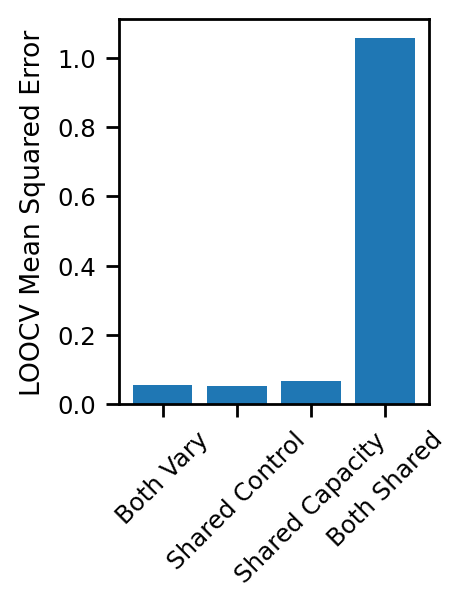

Python: Text(46.000000000000014, 0.5, 'LOOCV Mean Squared Error')

In [14]:

mses = [mean(full_res), mean(shared_eps_res), mean(shared_q_res), mean(shared_both_res)]
stds = [std(full_res), std(shared_eps_res), std(shared_q_res)]

fig,ax = subplots(1,dpi=200,figsize=(2,2.5))
ax.bar(1:4, mses)
ax.set_xticks(1:4, labels = ["Both Vary", "Shared Control", "Shared Capacity", "Both Shared"], rotation = 45)
ax.set_ylabel("LOOCV Mean Squared Error")
#ax.errorbar(1:3, mses, yerr = stds./sqrt(48))

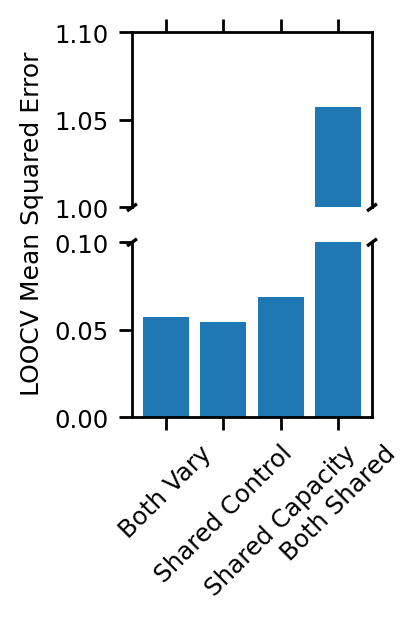

Python: None

In [117]:
mses = [mean(full_res), mean(shared_eps_res), mean(shared_q_res), mean(shared_both_res)]


f, (ax, ax2) = subplots(2, 1, figsize = (2,2.5), dpi = 200, sharex=true)
ax.bar(1:4, mses)
ax2.bar(1:4, mses)
ax.set_ylim(1, 1.1)  # outliers only
ax2.set_ylim(0, .1)  # outliers only
ax.spines["bottom"].set_visible(false)
# ax.set_xticks([])

ax2.spines["top"].set_visible(false)

ax.xaxis.tick_top()
# ax.tick_params(labeltop="off")  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

d = .015  # how big to make the diagonal lines in axes coordinates
#kwargs = Dict("transform"=>ax.transAxes, "color"=>"k", "clip_on"=>false)
ax.plot([-d, d], [-d, +d], transform = ax.transAxes, color = "k", clip_on = false)        # top-left diagonal
ax.plot([1-d, 1+d], [-d, +d], transform = ax.transAxes, color = "k", clip_on = false)        # top-left diagonal

ax2.plot([-d, d], [1-d, 1+d], transform = ax2.transAxes, color = "k", clip_on = false)        # top-left diagonal
ax2.plot([1-d, 1+d], [1-d, 1+d], transform = ax2.transAxes, color = "k", clip_on = false)        # top-left diagonal

ax2.set_xticks(1:4, labels = ["Both Vary", "Shared Control", "Shared Capacity", "Both Shared"], rotation = 45)
f.supylabel("LOOCV Mean Squared Error", fontsize=9)
f.subplots_adjust(left=.3)

In [190]:
shared_both_res

44-element Vector{Float64}:
 0.09470294608702039
 0.4919088326269475
 0.07672151263847131
 0.50603607515892
 0.4781618791850535
 1.3012602161509683
 1.0597667591284572
 1.8244659478313885
 0.151446884875045
 1.2219212050929456
 0.842809368835113
 1.3737497744423983
 0.03285863965180793
 ⋮
 2.5626830318606286
 0.09896973197024646
 3.939520762470951
 0.6208325490974252
 1.344522074602179
 1.7263817357544202
 1.658888680015293
 0.025037394532458616
 0.43124412209409396
 0.4091265506420106
 6.2061685075566455
 3.3675306903452884

In [131]:
mean(full_res) # adult_best_q_idx

0.05723112331230126

In [120]:
mean(shared_q_res)

0.0688755227041776

In [121]:
mean(shared_eps_res)

0.054416303710796025

In [86]:
adult_err_per_quanta

13.662226104158657

In [79]:
size(train_both_error)

(17, 20, 1)

In [56]:
adult_good_idxs = 1:24
child_good_idxs = 25:44

for h in held_out_idxs
    adult_good_idxs = adult_good_idxs[adult_good_idxs .!= h]
    child_good_idxs = child_good_idxs[child_good_idxs .!= h]
end

In [62]:
child_good_idxs

20-element Vector{Int64}:
 -23
 -23
 -23
 -23
 -23
 -23
 -23
 -23
 -23
 -23
 -23
 -23
 -23
 -23
 -23
 -23
 -23
 -23
 -23
 -23

In [43]:
size(full_child_error)

(17, 20, 20)

In [21]:
# now want to find params using all data points except for 1 or 2?

# find min error parameters, using all datapoints except for 1... this is for the full model...

child_mse_train = zeros(N_eps, N_q)
adult_mse_train = zeros(N_eps, N_q)

for (ep_idx, epsilon) in enumerate(eps_vals)
    for (q_idx, N_Quanta) in enumerate(q_vals)
        
        fullchild_mse_train[ep_idx, q_idx] = full_res_child



LoadError: UndefVarError: `these_exp_results` not defined

In [14]:
ep_idx = 1

full_res_child = [exp1_cowan_k_true_7_yr; exp2_cowan_k_true_7_yr; exp3_cowan_k_true_7_yr[:]] # 24...
# full_res_child = full_res_child[.!isnan.(full_res_child)] # 20 datapoints...

full_res_adult = [exp1_cowan_k_true_adult; exp2_cowan_k_true_adult; exp3_cowan_k_true_adult[:]]

24×1 Matrix{Float64}:
 1.98
 1.94
 1.97
 1.95
 3.87
 2.66
 3.64
 2.87
 3.54
 2.58
 3.58
 2.65
 2.63
 2.75
 2.75
 2.41
 2.38
 2.38
 4.8
 3.97
 3.97
 2.46
 2.15
 2.15

In [19]:
model_full_res

17×20×24 Array{Float64, 3}:
[:, :, 1] =
 0.373009  0.671312  0.837466  0.95459  …  1.5828   1.65002  1.636    1.70494
 0.441473  0.836928  1.12335   1.35752     1.98144  1.98363  1.99551  1.9851
 0.45249   0.969673  1.36108   1.59098     1.98759  1.98775  1.98577  1.98565
 0.516232  1.04426   1.40147   1.66361     1.99159  1.99375  1.98578  1.99167
 0.542201  1.08093   1.4341    1.65497     1.9756   1.98975  1.98977  1.99369
 0.581548  1.13908   1.46052   1.67745  …  1.9896   1.98175  1.98177  1.98971
 0.605156  1.16563   1.49314   1.67226     1.9836   1.98775  1.99377  1.99172
 0.621682  1.17322   1.49314   1.68264     1.99359  1.98775  1.98976  1.98772
 0.626403  1.17574   1.48227   1.68437     1.9896   1.98775  1.98776  1.98573
 0.656307  1.18965   1.4947    1.67918     1.9876   1.98775  1.98376  1.98573
 0.64529   1.17322   1.48848   1.67053  …  1.9836   1.98775  1.98377  1.98374
 0.691719  1.1808    1.48848   1.67226     1.9816   1.98775  1.98777  1.98374
 0.680702  1.18839   1.49

In [16]:
these_exp_results

LoadError: UndefVarError: `these_exp_results` not defined

In [10]:

# 48 values...

full_res = [exp1_cowan_k_true_7_yr; exp1_cowan_k_true_adult; exp2_cowan_k_true_7_yr; exp2_cowan_k_true_adult; exp3_cowan_k_true_7_yr[:]; exp3_cowan_k_true_adult[:]]

48×1 Matrix{Float64}:
 1.16
 1.14
 1.13
 1.02
 2.8
 0.91
 1.3
 0.96
 1.98
 1.94
 1.97
 1.95
 3.87
 ⋮
 2.63
 2.75
 2.75
 2.41
 2.38
 2.38
 4.8
 3.97
 3.97
 2.46
 2.15
 2.15

In [7]:
exp1_cowan_k_true_adult

8×1 adjoint(::Matrix{Float64}) with eltype Float64:
 1.98
 1.94
 1.97
 1.95
 3.87
 2.66
 3.64
 2.87

In [8]:
exp2_cowan_k_true_7_yr

4×1 adjoint(::Matrix{Float64}) with eltype Float64:
 1.55
 1.16
 1.0
 0.69